## Predict Group Stage World Cup 2022 Match

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf

In [2]:
data = "dataset/"
df_internationalmatches = pd.read_csv(data + "Results International Matches.csv")
df_wcmatches = pd.read_csv(data + "Data Predict.csv")

print(df_internationalmatches.shape)
print(df_wcmatches.shape)

(553, 19)
(48, 17)


In [3]:
df_internationalmatches.head()

,date,home_team,away_team,home_att,away_att,home_mid,away_mid,home_def,away_def,home_score,away_score,home_rank,away_rank,home_rankpoint,away_rankpoint,tournament,city,country,neutral
0,2018-09-06,Germany,France,84,82,85,85,85,82,0,0,15,1,1561.0,1726.0,UEFA Nations League,Munich,Germany,False
1,2018-09-06,Wales,Republic of Ireland,82,75,71,74,77,75,4,1,19,29,1536.0,1484.0,UEFA Nations League,Cardiff,Wales,False
2,2018-09-06,Slovenia,Bulgaria,72,70,76,69,72,67,1,2,55,47,1392.0,1416.0,UEFA Nations League,Ljubljana,Slovenia,False
3,2018-09-06,Austria,Sweden,80,76,77,75,75,75,2,0,23,13,1502.0,1565.0,Friendly,Vienna,Austria,False
4,2018-09-06,Netherlands,Peru,79,80,80,77,80,75,2,1,17,20,1540.0,1535.0,Friendly,Amsterdam,Netherlands,False


In [4]:
df_wcmatches.head()

,date,home_team,away_team,home_att,away_att,home_mid,away_mid,home_def,away_def,home_rank,away_rank,home_rankpoint,away_rankpoint,tournament,city,country,neutral
0,2022-11-20,Qatar,Ecuador,73,75,71,75,71,75,50,44,1439.89,1464.39,FIFA World Cup,Al Khor,Qatar,False
1,2022-11-21,England,Iran,86,81,83,73,83,72,5,20,1728.47,1564.61,FIFA World Cup,Al Rayyan,Qatar,True
2,2022-11-21,Senegal,Netherlands,79,82,76,82,77,83,18,8,1584.38,1694.51,FIFA World Cup,Doha,Qatar,True
3,2022-11-21,United States,Wales,77,78,78,76,76,77,16,19,1627.48,1569.82,FIFA World Cup,Al Rayyan,Qatar,True
4,2022-11-22,Argentina,Saudi Arabia,86,71,84,72,82,71,3,51,1773.88,1437.78,FIFA World Cup,Lusail,Qatar,True


In [5]:
label = LabelEncoder()
ohc = OneHotEncoder()
scaler = StandardScaler()

In [6]:
ftr = []
for i in range(len(df_internationalmatches)):
    if df_internationalmatches.home_score[i] > df_internationalmatches.away_score[i]:
        ftr.append(0)
    elif df_internationalmatches.home_score[i] < df_internationalmatches.away_score[i]:
        ftr.append(2)
    else:
        ftr.append(1)
df_internationalmatches.neutral = label.fit_transform(df_internationalmatches.neutral)
df_internationalmatches['FTR'] = ftr

In [7]:
columns = ['FTR', 'home_score', 'away_score', 'home_att', 'away_att', 'home_mid', 'away_mid', 'home_def', 'away_def', 'home_rank', 'away_rank', 'home_rankpoint', 'away_rankpoint', 'neutral']

df_internationalmatches = df_internationalmatches[columns]
df_internationalmatches.head()

,FTR,home_score,away_score,home_att,away_att,home_mid,away_mid,home_def,away_def,home_rank,away_rank,home_rankpoint,away_rankpoint,neutral
0,1,0,0,84,82,85,85,85,82,15,1,1561.0,1726.0,0
1,0,4,1,82,75,71,74,77,75,19,29,1536.0,1484.0,0
2,2,1,2,72,70,76,69,72,67,55,47,1392.0,1416.0,0
3,0,2,0,80,76,77,75,75,75,23,13,1502.0,1565.0,0
4,0,2,1,79,80,80,77,80,75,17,20,1540.0,1535.0,0


In [8]:
y_train_predict = ohc.fit_transform(df_internationalmatches['FTR'].to_numpy().reshape(-1,1)).toarray()
X_train = scaler.fit_transform(df_internationalmatches.iloc[:,3:].astype(float))

In [9]:
df_wcmatches.neutral = label.fit_transform(df_wcmatches.neutral)
X_test = scaler.fit_transform(df_wcmatches[['home_att', 'away_att', 'home_mid', 'away_mid', 'home_def', 'away_def', 'home_rank', 'away_rank', 'home_rankpoint', 'away_rankpoint', 'neutral']].astype(float))

In [10]:
def plot_graph_accuracy(history, accuracy):
    plt.plot(history.history[accuracy])
    plt.xlabel("Epochs")
    plt.ylabel(accuracy)
    plt.show()
    
def plot_graph_loss(history, loss):
    plt.plot(history.history[loss])
    plt.xlabel("Epochs")
    plt.ylabel(loss)
    plt.show()

### Model predict matches in 90 minutes (Probability Home win, Draw, Away Win)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_dim=X_train.shape[1], activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.002, l2=0.0005)),
    tf.keras.layers.Dense(10, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.002, l2=0.0005)),
    tf.keras.layers.Dense(y_train_predict.shape[1], activation='softmax')
])

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_predict, batch_size=10, epochs=500)

Epoch 1/500
56/56 [==============================] - 3s 4ms/step - loss: 1.3560 - accuracy: 0.3653
Epoch 2/500
56/56 [==============================] - 0s 2ms/step - loss: 1.2947 - accuracy: 0.4792
Epoch 3/500
56/56 [==============================] - 0s 3ms/step - loss: 1.2577 - accuracy: 0.5136
Epoch 4/500
56/56 [==============================] - 0s 2ms/step - loss: 1.2353 - accuracy: 0.5262
Epoch 5/500
56/56 [==============================] - 0s 2ms/step - loss: 1.2229 - accuracy: 0.5172
Epoch 6/500
56/56 [==============================] - 0s 2ms/step - loss: 1.2146 - accuracy: 0.5353
Epoch 7/500
56/56 [==============================] - 0s 2ms/step - loss: 1.2088 - accuracy: 0.5335
Epoch 8/500
56/56 [==============================] - 0s 3ms/step - loss: 1.2034 - accuracy: 0.5425
Epoch 9/500
56/56 [==============================] - 0s 2ms/step - loss: 1.1984 - accuracy: 0.5371
Epoch 10/500
56/56 [==============================] - 0s 3ms/step - loss: 1.1951 - accuracy: 0.5443
Epoch 11/

56/56 [==============================] - 0s 2ms/step - loss: 1.0651 - accuracy: 0.5660
Epoch 83/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0640 - accuracy: 0.5696
Epoch 84/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0635 - accuracy: 0.5624
Epoch 85/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0619 - accuracy: 0.5696
Epoch 86/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0602 - accuracy: 0.5642
Epoch 87/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0597 - accuracy: 0.5750
Epoch 88/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0582 - accuracy: 0.5696
Epoch 89/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0578 - accuracy: 0.5732
Epoch 90/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0558 - accuracy: 0.5714
Epoch 91/500
56/56 [==============================] - 0s 3ms/step - loss: 1.0553 - accuracy: 0.5732
Epoch 92/500


56/56 [==============================] - 0s 3ms/step - loss: 1.0010 - accuracy: 0.5823
Epoch 164/500
56/56 [==============================] - 0s 2ms/step - loss: 1.0002 - accuracy: 0.5787
Epoch 165/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9996 - accuracy: 0.5750
Epoch 166/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9989 - accuracy: 0.5859
Epoch 167/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9991 - accuracy: 0.5877
Epoch 168/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9984 - accuracy: 0.5877
Epoch 169/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9975 - accuracy: 0.5805
Epoch 170/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9966 - accuracy: 0.5823
Epoch 171/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9968 - accuracy: 0.5750
Epoch 172/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9964 - accuracy: 0.5805
Epoc

56/56 [==============================] - 0s 2ms/step - loss: 0.9664 - accuracy: 0.5895
Epoch 245/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9657 - accuracy: 0.5823
Epoch 246/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9654 - accuracy: 0.5895
Epoch 247/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9657 - accuracy: 0.5877
Epoch 248/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9651 - accuracy: 0.5841
Epoch 249/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9648 - accuracy: 0.5877
Epoch 250/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9645 - accuracy: 0.5823
Epoch 251/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9629 - accuracy: 0.5895
Epoch 252/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9636 - accuracy: 0.5841
Epoch 253/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9625 - accuracy: 0.5913
Epoc

56/56 [==============================] - 0s 2ms/step - loss: 0.9433 - accuracy: 0.5967
Epoch 325/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9444 - accuracy: 0.5913
Epoch 326/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9426 - accuracy: 0.5895
Epoch 327/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9438 - accuracy: 0.5895
Epoch 328/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9441 - accuracy: 0.5949
Epoch 329/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9415 - accuracy: 0.5859
Epoch 330/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9448 - accuracy: 0.5841
Epoch 331/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9426 - accuracy: 0.5877
Epoch 332/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9434 - accuracy: 0.5859
Epoch 333/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9423 - accuracy: 0.5949
Epoc

56/56 [==============================] - 0s 3ms/step - loss: 0.9316 - accuracy: 0.6004
Epoch 405/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.5895
Epoch 406/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9318 - accuracy: 0.5895
Epoch 407/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9317 - accuracy: 0.5769
Epoch 408/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9325 - accuracy: 0.5967
Epoch 409/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9324 - accuracy: 0.5967
Epoch 410/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9332 - accuracy: 0.6004
Epoch 411/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9334 - accuracy: 0.5931
Epoch 412/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9327 - accuracy: 0.6004
Epoch 413/500
56/56 [==============================] - 0s 3ms/step - loss: 0.9314 - accuracy: 0.5877
Epoc

56/56 [==============================] - 0s 3ms/step - loss: 0.9244 - accuracy: 0.6040
Epoch 485/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9256 - accuracy: 0.6040
Epoch 486/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9249 - accuracy: 0.6004
Epoch 487/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9281 - accuracy: 0.5913
Epoch 488/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9265 - accuracy: 0.5859
Epoch 489/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9233 - accuracy: 0.6022
Epoch 490/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9245 - accuracy: 0.6112
Epoch 491/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9271 - accuracy: 0.6094
Epoch 492/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9252 - accuracy: 0.6022
Epoch 493/500
56/56 [==============================] - 0s 2ms/step - loss: 0.9266 - accuracy: 0.5931
Epoc

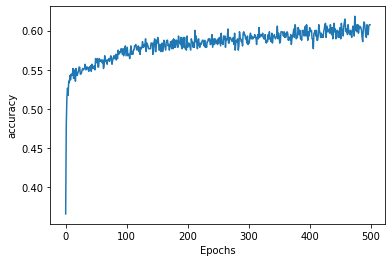

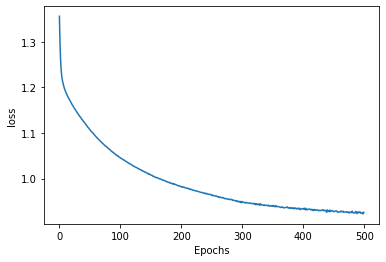

In [13]:
plot_graph_accuracy(history, 'accuracy')
plot_graph_loss(history, 'loss')

In [14]:
prob = model.predict(X_test)
print('Probability Result Group Stage World Cup 2022 Match')
print('===================================================')
for i in range(len(df_wcmatches)):
    print(f'{df_wcmatches.home_team[i]} vs {df_wcmatches.away_team[i]}')
    print(f'Home Win: {prob[i][0]:.5f}  Draw: {prob[i][1]:.5f}  Away Win: {prob[i][2]:.5f}\n')

Probability Result Group Stage World Cup 2022 Match
Qatar vs Ecuador
Home Win: 0.85547  Draw: 0.11256  Away Win: 0.03197

England vs Iran
Home Win: 0.63246  Draw: 0.23398  Away Win: 0.13356

Senegal vs Netherlands
Home Win: 0.09060  Draw: 0.29440  Away Win: 0.61501

United States vs Wales
Home Win: 0.47414  Draw: 0.31862  Away Win: 0.20724

Argentina vs Saudi Arabia
Home Win: 0.78110  Draw: 0.18123  Away Win: 0.03767

Denmark vs Tunisia
Home Win: 0.71641  Draw: 0.22999  Away Win: 0.05361

Mexico vs Poland
Home Win: 0.42425  Draw: 0.23135  Away Win: 0.34440

France vs Australia
Home Win: 0.75273  Draw: 0.19674  Away Win: 0.05053

Morocco vs Croatia
Home Win: 0.10784  Draw: 0.41413  Away Win: 0.47804

Germany vs Japan
Home Win: 0.71122  Draw: 0.23568  Away Win: 0.05310

Spain vs Costa Rica
Home Win: 0.79217  Draw: 0.17426  Away Win: 0.03357

Belgium vs Canada
Home Win: 0.75607  Draw: 0.20171  Away Win: 0.04222

Switzerland vs Cameroon
Home Win: 0.52786  Draw: 0.28439  Away Win: 0.18774

